# We are not providing you with any code for this assignment, so you must code everything yourself. However, we are providing you with an example notebook on how to run an MCMC.
# Furthermore, we provide a noise-free and noisy reference model from which you must derive parameters. Lastly, we give you three noisy covariance matrices.
# We recommend running the MCMC not in a Jupyter Notebook but instead using an external Python script.

In [170]:
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy.linalg import inv
from cosmopower_NN import cosmopower_NN
import tensorflow as tf
import gc
from getdist import plots, MCSamples, parampriors
import getdist
import emcee

In [236]:
cov=np.load('data_4_assignment3/covariance.npy')
cov_inv = inv(cov)

minimum=np.load('data_4_assignment3/minimum.npy')
maximum=np.load('data_4_assignment3/maximum.npy')

reference_model = np.load('data_4_assignment3/reference_model.npy')
reference_model_noisy = np.load('data_4_assignment3/reference_model_noise.npy')

cp_nn_model = cosmopower_NN(restore=True, restore_filename='data_4_assignment3/emulator_final')

cov_num_1500 = np.load('data_4_assignment3/cov_num_1500.npy')
cov_num_3000 = np.load('data_4_assignment3/cov_num_3000.npy')
cov_num_10000 = np.load('data_4_assignment3/cov_num_10000.npy')

inv_cov_num_1500, inv_cov_num_3000, inv_cov_num_10000 = inv(cov_num_1500), inv(cov_num_3000), inv(cov_num_10000)

## You can use any sampler you like to use for the following tasks. Also, you can use your own emulator. You must use the noisy reference model for the first three tasks. Check for each task, check that the posteriors and the $\chi^2$ distributions are as expected.
## Your tasks for this week are the following:


### 1. Run an MCMC where you vary all four parameters you have trained on your emulator.

In [103]:
import emcee
import multiprocess as mp
import os 

total_steps = 2000 # total  number of steps each walker is doing
burning_steps = 200 # how many buring steps you want to remove
nwalkers = 10 # Number of walkers that probe the parameter space

num_threads = 30 # number of cpu cores to use

#which paramters we want to vary
parameters = np.load('data_4_assignment2/parameters.npz')
param_names_varying = parameters.files #['omega_m', 'As'] # alternatively you can also just use parameters.files
ndim = len(param_names_varying)

# print(list(np.array(parameters[name])[55]))
reference_params = {}
for name in parameters.keys():
    reference_params[name] = np.array(parameters[name])[55] #list(np.array(parameters[name])[55])

In [104]:
param_names_varying

['omega_m', 'omega_b', 'As', 'w']

In [105]:
## a function that distributed start postions inside the trained parameters
def start_position_lh_and_step_size(seed):
    random.seed(seed)
    p0 = []
    for i in range(nwalkers):
        random_starts = []
        
        for name in param_names_varying:
            lower_edge = np.min(parameters[name])
            upper_edge = np.max(parameters[name])
            
            if name == 'omega_b':
                lower_edge = 0.035
                upper_edge = 0.055
            if name == 'omega_m':
                lower_edge = 0.3
                upper_edge = 0.38
            if name == 'As':
                lower_edge = 1.8e-9
                upper_edge = 2.3e-9
            if name == 'w':
                lower_edge = -2
                upper_edge = -1
            
            # if(lower_edge<0):
            #     lower_edge = lower_edge * 0.69
            # else:
            #     lower_edge = lower_edge * 1.11
            # if(upper_edge>0):
            #     upper_edge = upper_edge * 0.69
            # else:
            #     upper_edge = upper_edge * 1.11     
           
            # print(name)     
            # print(lower_edge, upper_edge)     
            random_starts.append(random.uniform(lower_edge,upper_edge))

        p0.append(random_starts)
        
    return np.array(p0)

In [106]:
## function that computes our priors. Here we only allow the walker to be inside the training range. You can also define Gaussian priors. 
def cal_logprior(para_dict):

    lnprior = 0
    #cosmological priors
    for name in param_names_varying:
        if(para_dict[name]>np.max(parameters[name])):
            lnprior = -np.inf
        if(para_dict[name]<np.min(parameters[name])):
            lnprior = -np.inf
    
    return lnprior

In [112]:
## Function that computes the likelihood
def calc_likelihood(para):
    
    params = {'omega_b':reference_params['omega_b'],'w':reference_params['w'], 'omega_m':reference_params['omega_m'], 'As':reference_params['As']}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    # print(params)

    pred_vector = cp_nn_model.predictions_np(params)[0]
    pred_vector = pred_vector*maximum+minimum 
    
    # print(pred_vector.shape,reference_model.shape,cov_inv.shape)
    
    delta = pred_vector - reference_model_noisy
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior
 

In [108]:
print(emcee.__version__)
p0 = start_position_lh_and_step_size(0)

3.1.4


In [109]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_emcee = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_s2000_burn200_walk10_emcee',samples_emcee)
log_prob_samples = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_s2000_burn200_walk10_emcee',log_prob_samples)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [02:27<00:00, 13.59it/s]


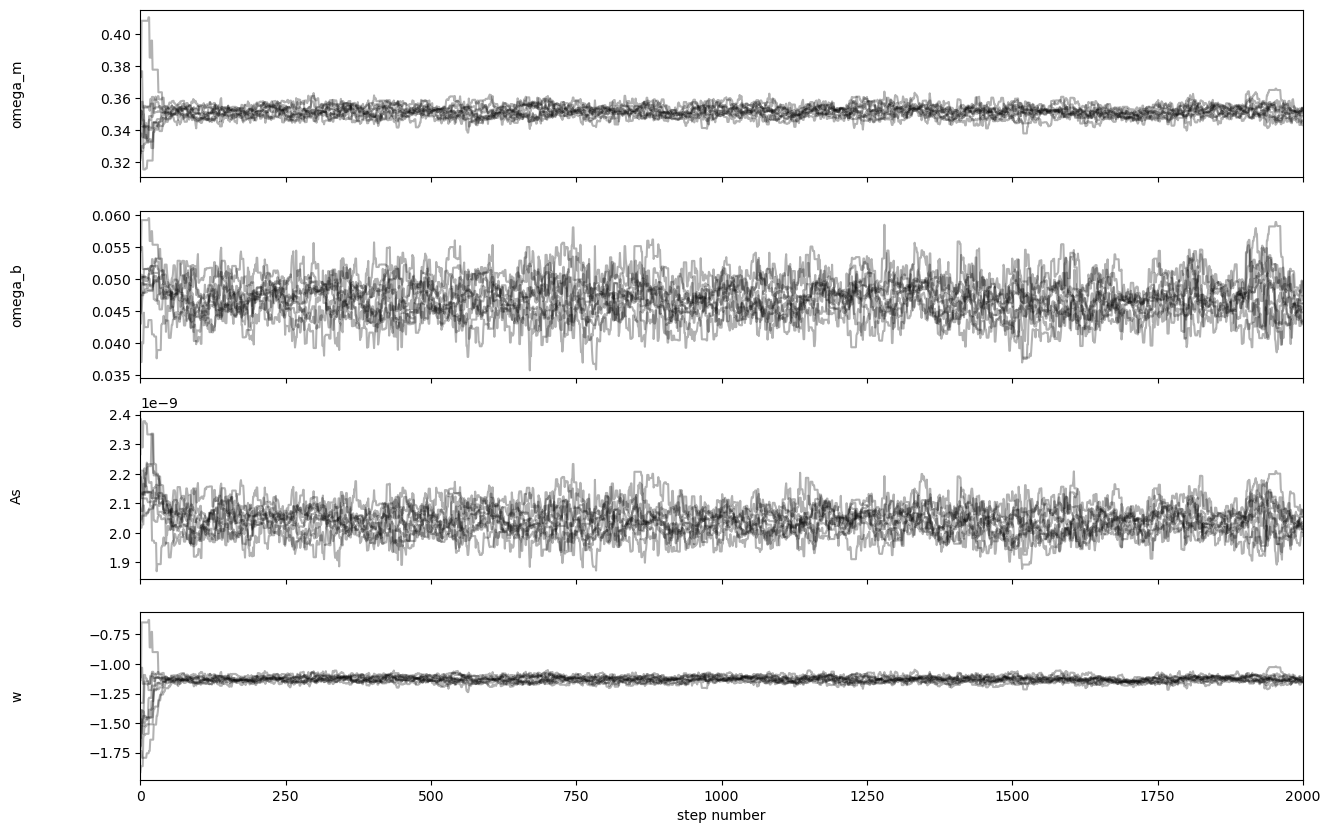

In [110]:
fig, axes = plt.subplots(ndim, figsize=(15, 10), sharex=True)
samples = sampler.get_chain()
labels = param_names_varying #["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

plt.savefig('plots_4_assignment3/MCMC_chain_task1.jpg',dpi=400, bbox_inches='tight')

Removed no burn in


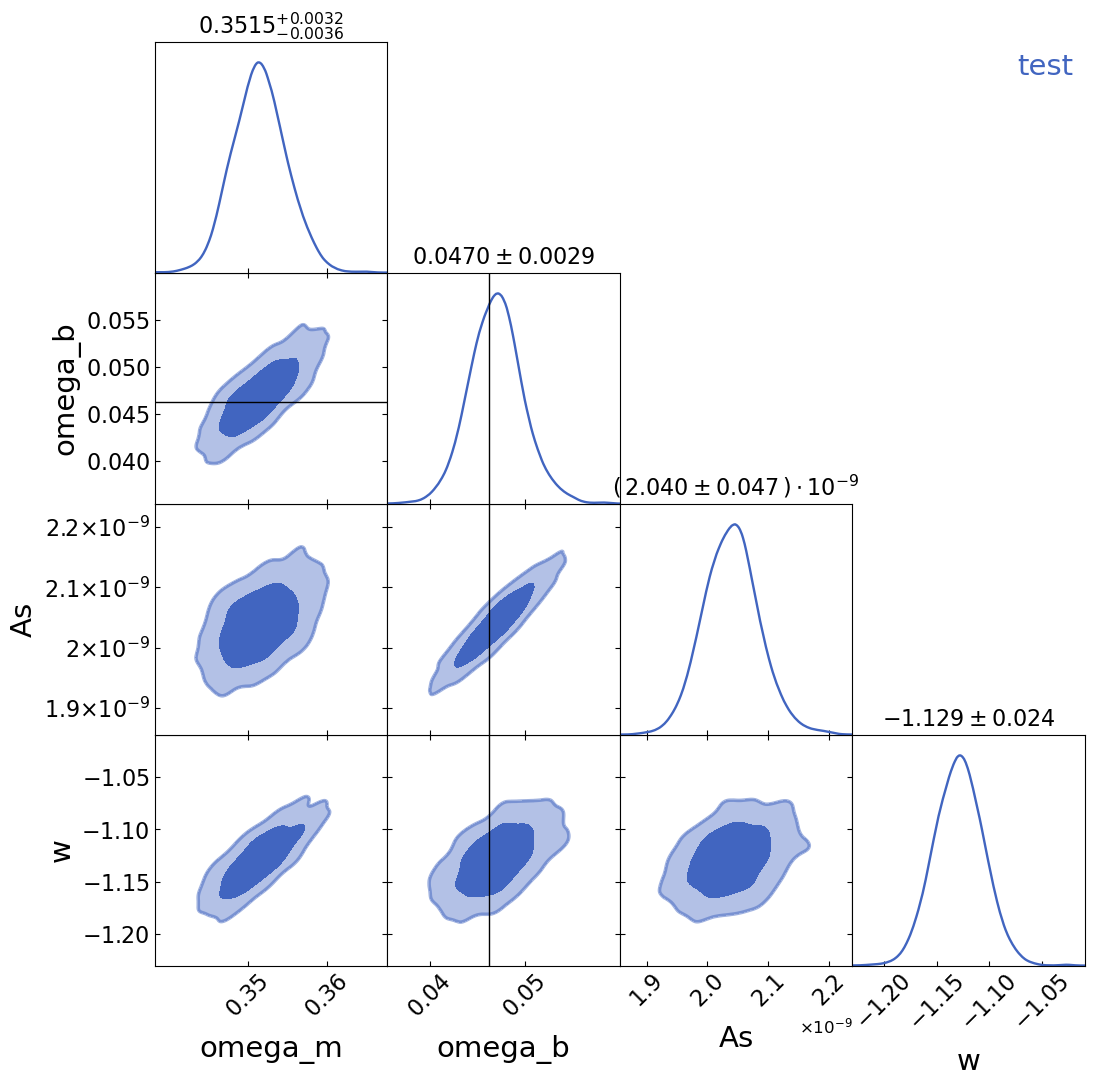

In [111]:
from getdist import plots, MCSamples, parampriors
import getdist

samples_emcee = np.load('data_4_assignment3/outputs_MCMC/MCMC_s2000_burn200_walk10_emcee')

para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])#[[0,2]]
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])


samples_getdist = MCSamples(samples=samples_emcee,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=[samples_getdist],
    filled=True,
    legend_loc='upper right',
    legend_labels = ['Task #1'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots_4_assignment3/MCMC_corner_task1.jpg',dpi=400, bbox_inches='tight')


Comments:

I noticed that regardless or how many walkers or steps I ran my MCMC for, there were always some walkers getting stuck in what is presumed to be a local minima. This obviously, throuhg off the results and constraints obtained for each of the four parameters. To fix this, in the 'start_position_lh_and_step_size' function which is used to get the random starting positions for all the walkers, I hardcoded in a lower- and upper-edge value for all the parameters. I determined these values based on previous interations of running the MCMC and seeing on the corner plot the range of values for which the walkers converged.

<h1 style="color:red"> DO CHI2 DISTRIBUTION!</h1>

### 2. Use the provided numerical covariance matrices with [1.5k,3k,10k] data vectors as in assignment one. Run an MCMC for all of them with and without Hartlap correction, and compare with your results. Link your results to assignment one.

#### 1.5k Numerical Covariance Matrix

In [142]:
total_steps = 1000 # total  number of steps each walker is doing
burning_steps = 100 # how many buring steps you want to remove
nwalkers = 10 # Number of walkers that probe the parameter space

num_threads = 30 # number of cpu cores to use

#which paramters we want to vary
parameters = np.load('data_4_assignment2/parameters.npz')
param_names_varying = parameters.files #['omega_m', 'As'] # alternatively you can also just use parameters.files
ndim = len(param_names_varying)

In [193]:
## Function that computes the likelihood

# inv_cov_num_1500, inv_cov_num_3000, inv_cov_num_10000
def calc_likelihood_hartlap(para, inv_cov, realizations, dimensions):
    
    params = {'omega_b':reference_params['omega_b'],'w':reference_params['w'], 'omega_m':reference_params['omega_m'], 'As':reference_params['As']}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    # print(params)
    
    n_r = realizations # number of realisations used  # this is the length of the numerical covariance matrix used or is it 900?
    n_d = dimensions # dimension of the model 
    h = (n_r-1)/(n_r-n_d-2)
    cov_inv_hartlap = inv_cov/h

    pred_vector = cp_nn_model.predictions_np(params)[0]
    pred_vector = pred_vector*maximum+minimum 
    

    # print(pred_vector.shape,reference_model.shape,cov_inv.shape)
    
    delta = pred_vector - reference_model_noisy
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv_hartlap,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior

def calc_likelihood_nohartlap(para, inv_cov):
    
    params = {'omega_b':reference_params['omega_b'],'w':reference_params['w'], 'omega_m':reference_params['omega_m'], 'As':reference_params['As']}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]


    pred_vector = cp_nn_model.predictions_np(params)[0]
    pred_vector = pred_vector*maximum+minimum 
    

    # print(pred_vector.shape,reference_model.shape,cov_inv.shape)
    
    delta = pred_vector - reference_model_noisy
    likelihood = -0.5*np.matmul(delta,np.matmul(inv_cov,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior

In [199]:
def run_and_save_hartlap_nohartlap_MCMC(inv_cov_num, save_names, realizations, dimensions):
    
    # MCMC but WE DO apply the Hartlap factor
    sampler_hartlap = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_hartlap, args=[inv_cov_num, realizations, dimensions])
    sampler_hartlap.run_mcmc(p0, total_steps, progress=True)

    samples_emcee_hartlap = sampler_hartlap.get_chain(discard=burning_steps,flat=True)
    np.save('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_'+save_names[0], samples_emcee_hartlap)
    log_prob_samples_hartlap = sampler_hartlap.get_log_prob(discard=burning_steps, flat=True)
    np.save('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_'+save_names[0], log_prob_samples_hartlap)
    
    # MCMC but NOT applying the Hartlap factor
    sampler_nohartlap = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_nohartlap, args=[inv_cov_num])
    sampler_nohartlap.run_mcmc(p0, total_steps, progress=True)

    samples_emcee_nohartlap = sampler_nohartlap.get_chain(discard=burning_steps,flat=True)
    np.save('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_'+save_names[1], samples_emcee_nohartlap)
    log_prob_samples_nohartlap = sampler_nohartlap.get_log_prob(discard=burning_steps, flat=True)
    np.save('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_'+save_names[1], log_prob_samples_nohartlap)

In [195]:
def plot_and_save_mcmc_chain(mcmc_sampler, save_name, title):
    fig, axes = plt.subplots(ndim, figsize=(15, 10), sharex=True)
    samples = mcmc_sampler.get_chain()
    labels = param_names_varying #["m", "b", "log(f)"]
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    plt.title(title)

    plt.savefig('plots_4_assignment3/MCMC_chain_'+save_name+'.jpg',dpi=400, bbox_inches='tight')

In [206]:
def plot_and_save_hartlap_corner(samples_emcee_hartlap, samples_emcee_nohartlap, save_name, labels):

    para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])#[[0,2]]
    param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

    parameters = np.load('data_4_assignment2/parameters.npz')
    parameters.keys()
    para_priors = {}
    para_priors_low = {}
    para_priors_up = {}
    for name in para_names:
        para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
        para_priors_low[name] = np.min(parameters[name])
        para_priors_up[name] = np.max(parameters[name])


    samples_emcee_hartlap = np.load('data_4_assignment3/outputs_MCMC/'+samples_emcee_hartlap)
    samples_emcee_nohartlap = np.load('data_4_assignment3/outputs_MCMC/'+samples_emcee_nohartlap)
    
    samples_getdist_hartlap = MCSamples(samples=samples_emcee_hartlap,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
    samples_getdist_nohartlap = MCSamples(samples=samples_emcee_nohartlap,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})

    colors = ['lightcoral', 'royalblue', 'orange']
    bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
    retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

    g = plots.get_subplot_plotter(width_inch=12)
    g.settings.axis_marker_lw = 1.0
    g.settings.axis_marker_ls = '-'
    g.settings.title_limit_labels = False
    g.settings.axis_marker_color = 'k'
    g.settings.legend_colored_text = True
    g.settings.figure_legend_frame = False
    g.settings.linewidth = 2.0
    g.settings.linewidth_contour = 3.0
    g.settings.legend_fontsize = 22
    g.settings.axes_fontsize = 17
    g.settings.axes_labelsize = 22
    g.settings.axis_tick_x_rotation = 45
    g.settings.axis_tick_max_labels = 6
    g.settings.solid_colors = retro

    priors = parampriors.ParamBounds()
    # priors.names = para_names
    # priors.lower = para_priors_low
    # priors.upper = para_priors_up

    g.triangle_plot(
        roots=[samples_getdist_hartlap, samples_getdist_nohartlap],
        filled=True,
        legend_loc='upper right',
        legend_labels = labels,
        title_limit=1,
        # upper_roots=[1,2,0],
        # param_limits=para_priors,
        markers=reference_params,
    )

    #plt.title('1.5k')
    plt.savefig('plots_4_assignment3/MCMC_corner_'+save_name+'.jpg',dpi=400, bbox_inches='tight')


In [177]:
p0 = start_position_lh_and_step_size(0)

In [200]:
run_and_save_hartlap_nohartlap_MCMC(inv_cov_num_1500, ['numcov1500_hartlap', 'numcov1500_nohartlap'], 1500, 900)

  0%|          | 1/1000 [00:00<01:43,  9.65it/s]

100%|██████████| 1000/1000 [01:08<00:00, 14.68it/s]


Removed no burn in
Removed no burn in


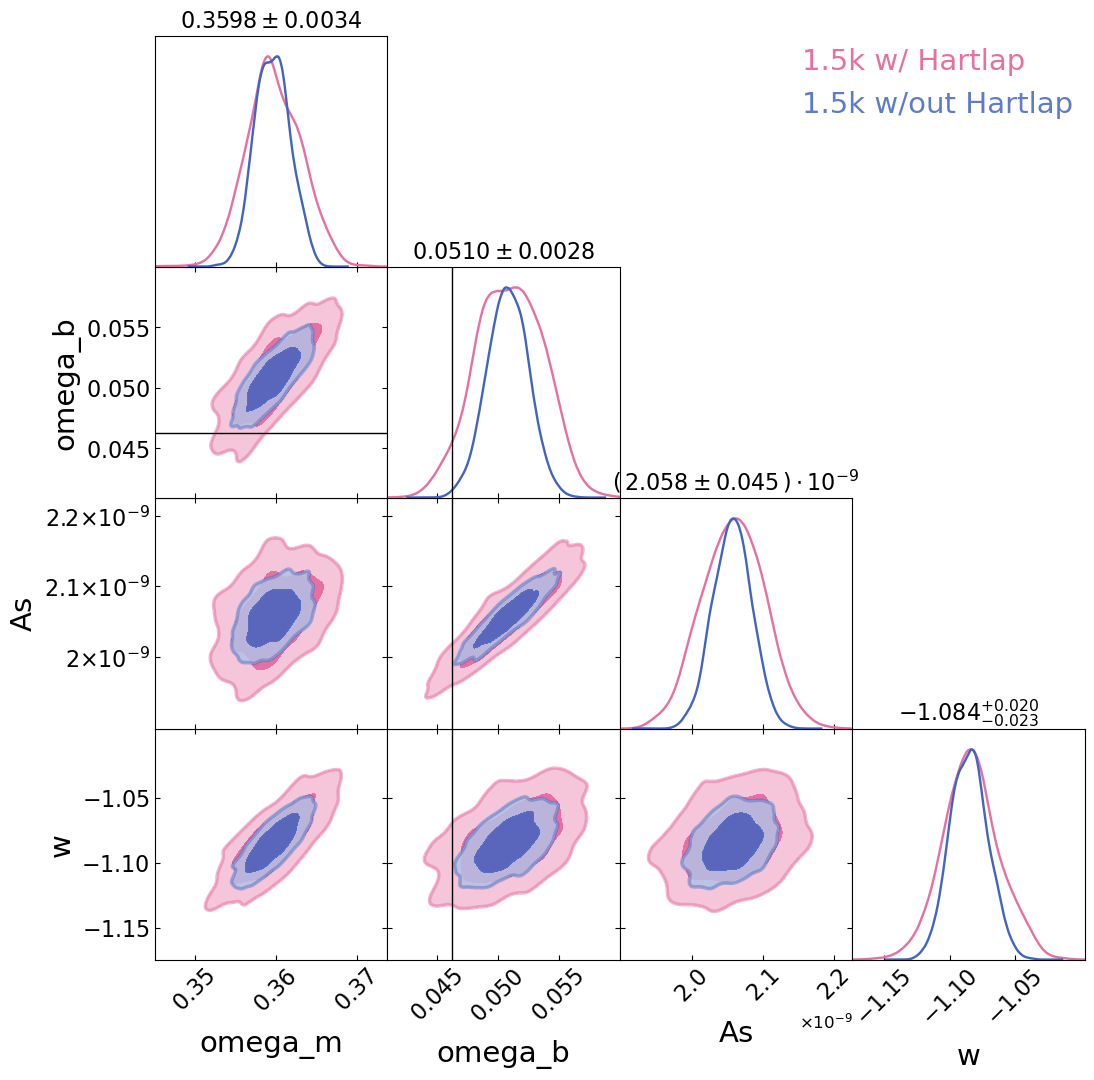

In [207]:
plot_and_save_hartlap_corner('MCMC_s1000_burn100_walk10_emcee_numcov1500_hartlap.npy', 'MCMC_s1000_burn100_walk10_emcee_numcov1500_nohartlap.npy', 
                             'task2_1500covnum', ['1.5k w/ Hartlap','1.5k w/out Hartlap'])

<h1 style="color:red"> DO CHI2 DISTRIBUTION!</h1>

#### 3K Numerical Covariance Matrix

In [208]:
run_and_save_hartlap_nohartlap_MCMC(inv_cov_num_3000, ['numcov3000_hartlap', 'numcov3000_nohartlap'], 3000, 900)

  0%|          | 1/1000 [00:00<01:50,  9.03it/s]

100%|██████████| 1000/1000 [01:07<00:00, 14.90it/s]


Removed no burn in
Removed no burn in


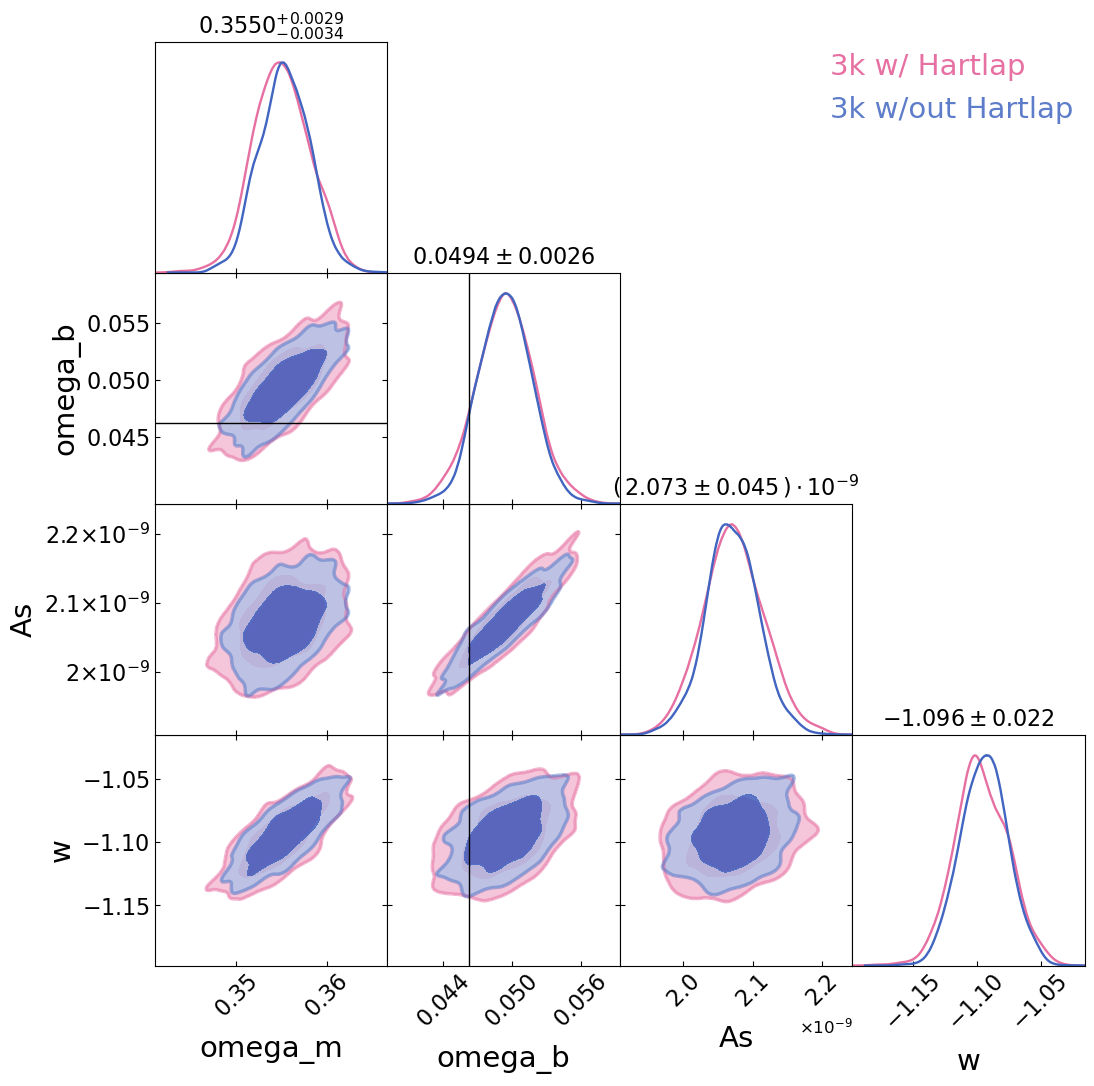

In [210]:
plot_and_save_hartlap_corner('MCMC_s1000_burn100_walk10_emcee_numcov3000_hartlap.npy', 'MCMC_s1000_burn100_walk10_emcee_numcov3000_nohartlap.npy', 
                             'task2_3000covnum',['3k w/ Hartlap','3k w/out Hartlap'])

<h1 style="color:red"> DO CHI2 DISTRIBUTION!</h1>

#### 10K Numerical Covariance Matrix

In [211]:
run_and_save_hartlap_nohartlap_MCMC(inv_cov_num_10000, ['numcov10000_hartlap', 'numcov10000_nohartlap'], 10000, 900)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:04<00:00, 15.45it/s]


Removed no burn in
Removed no burn in


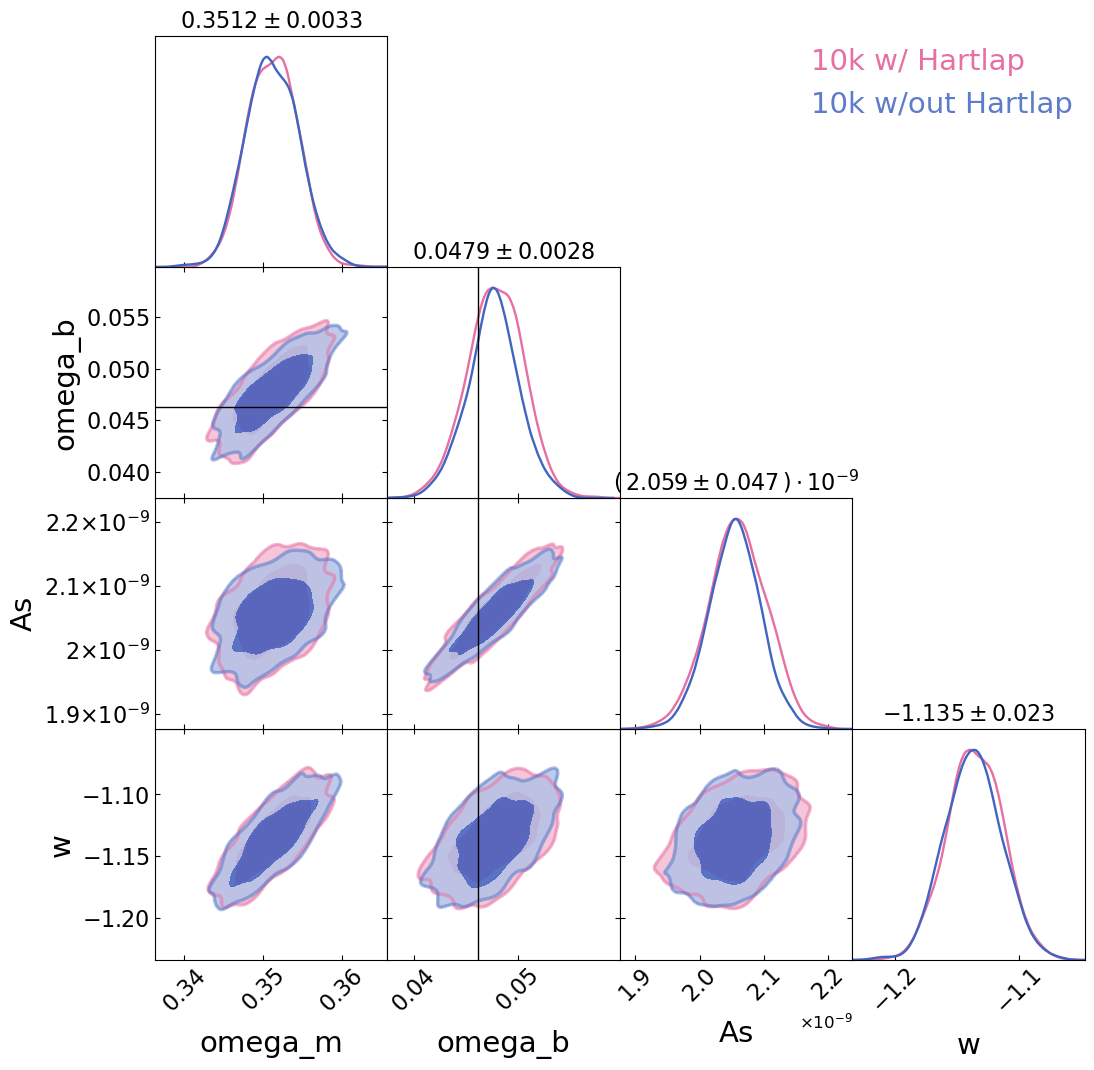

In [212]:
plot_and_save_hartlap_corner('MCMC_s1000_burn100_walk10_emcee_numcov10000_hartlap.npy', 'MCMC_s1000_burn100_walk10_emcee_numcov10000_nohartlap.npy', 
                             'task2_10000covnum', ['10k w/ Hartlap','10k w/out Hartlap'])

<h1 style="color:red"> DO CHI2 DISTRIBUTION!</h1>

In [213]:
samples_emcee_hartlap_1500 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s1000_burn100_walk10_emcee_numcov1500_hartlap.npy')
samples_emcee_nohartlap_1500 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s1000_burn100_walk10_emcee_numcov1500_nohartlap.npy')

samples_emcee_hartlap_3000 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s1000_burn100_walk10_emcee_numcov3000_hartlap.npy')
samples_emcee_nohartlap_3000 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s1000_burn100_walk10_emcee_numcov3000_nohartlap.npy')

samples_emcee_hartlap_10000 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s1000_burn100_walk10_emcee_numcov10000_hartlap.npy')
samples_emcee_nohartlap_10000 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s1000_burn100_walk10_emcee_numcov10000_nohartlap.npy')

In [233]:
# a = samples_getdist_hartlap.getInlineLatex('As',limit=1)
# a
# # test = samples_getdist_hartlap.getMargeStats()
# # lims0 = test.parWithName('w').limits

# # print(len(lims0))
# # print(lims0[0].upper, lims0[1].upper, lims0[2].upper)

<h1 style="color:red"> Make a table summarizing the parameter constraints found for each numerical cov and for hartlap vs. no hartlap</h1>

<table>
    <thead>
        <tr>
            <th>Layer 1</th>
            <th>Layer 2</th>
            <th>Layer 3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=4>L1 Name</td>
            <td rowspan=2>L2 Name A</td>
            <td>L3 Name A</td>
        </tr>
        <tr>
            <td>L3 Name B</td>
        </tr>
        <tr>
            <td rowspan=2>L2 Name B</td>
            <td>L3 Name C</td>
        </tr>
        <tr>
            <td>L3 Name D</td>
        </tr>
    </tbody>
</table>

|             |          Grouping           ||
First Header  | Second Header | Third Header |
 ------------ | :-----------: | -----------: |
Content       |          *Long Cell*        ||
Content       |   **Cell**    |         Cell |

New section   |     More      |         Data |
And more      | With an escaped '\|'         ||

### 3. Next, we consider PCA data compression. Run an MCMC for several numbers of PCA elements. Link your results to assignment two.

####    3.a. Use the analytical covariance matrix.

In [270]:
## Function that computes the likelihood
def calc_likelihood_PCA(para, cov_inv_pca, N_pca, pca):
    
    params = {'omega_b':reference_params['omega_b'],'w':reference_params['w'], 'omega_m':reference_params['omega_m'], 'As':reference_params['As']}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    pred_vector = cp_nn_model.predictions_np(params)[0]
    pred_vector_transformed = pca.transform([pred_vector*maximum+minimum])[0]
    
    reference_model_noisy_transformed = pca.transform([reference_model_noisy])[0]
       
    # print(pred_vector.shape,reference_model.shape,cov_inv_pca.shape)
    
    delta = pred_vector_transformed - reference_model_noisy_transformed
    
    
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv_pca,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior

In [280]:
models = np.load('data_4_assignment2/models.npy')
mean = np.mean(models,axis=0) # for numerical stability you should subtract the mean of each element


for N_pca in [100,300,600,900]:#tqdm(np.arange(1,900)):
    
    pca = PCA(n_components=N_pca,svd_solver='full')
    models_pca = pca.fit(models-mean) # Perform the PCA fitting. Now you can use pca for the transformation
    
    # Rotating the covariance matrix
    rotation_matrix = pca.components_.T
    cov_pca = rotation_matrix.T @ cov @ rotation_matrix 
    
    inv_cov_pca = inv(cov_pca) # select the first N_pca elements

    
    sampler_pca = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_PCA, args=[inv_cov_pca, N_pca, pca])
    sampler_pca.run_mcmc(p0, total_steps, progress=True)
    
    samples_emcee_pca = sampler_pca.get_chain(discard=burning_steps,flat=True)
    np.save('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_pca'+str(N_pca), samples_emcee_pca)
    log_prob_samples_pca = sampler_pca.get_log_prob(discard=burning_steps, flat=True)
    np.save('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_pca'+str(N_pca), log_prob_samples_pca)
    

100%|██████████| 1000/1000 [01:17<00:00, 12.84it/s]


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


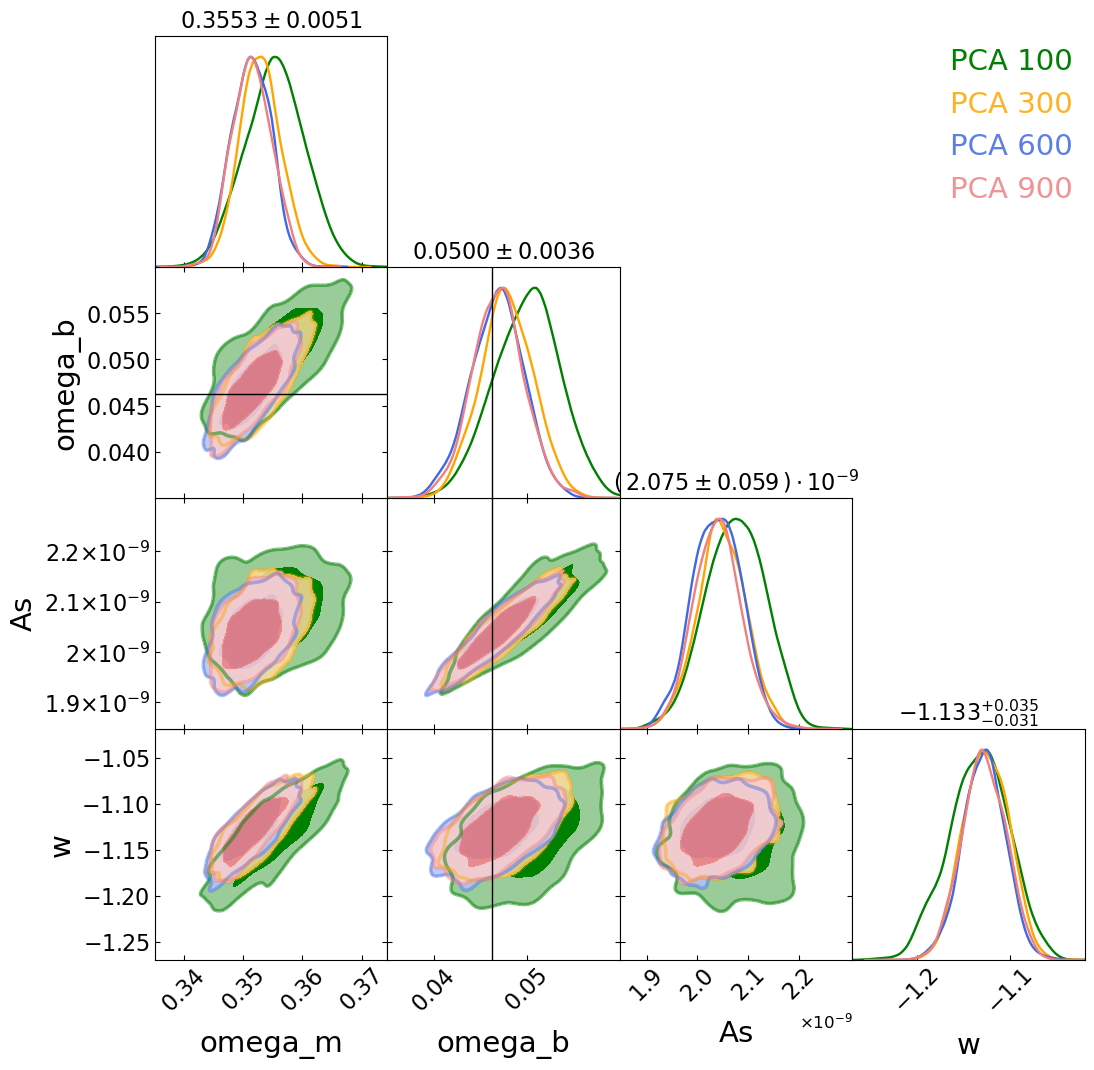

In [281]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])#[[0,2]]
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])


samples_emcee_pca100 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_pca100.npy')
samples_emcee_pca300 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_pca300.npy')
samples_emcee_pca600 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_pca600.npy')
samples_emcee_pca900 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_pca900.npy')

samples_getdist_pca100 = MCSamples(samples=samples_emcee_pca100,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
samples_getdist_pca300 = MCSamples(samples=samples_emcee_pca300,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
samples_getdist_pca600 = MCSamples(samples=samples_emcee_pca600,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
samples_getdist_pca900 = MCSamples(samples=samples_emcee_pca900,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})


colors = ['lightcoral', 'royalblue', 'orange', 'green']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = colors

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=[samples_getdist_pca100, samples_getdist_pca300, samples_getdist_pca600, samples_getdist_pca900],
    filled=True,
    legend_loc='upper right',
    legend_labels = ['PCA 100','PCA 300', 'PCA 600', 'PCA 900' ],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots_4_assignment3/MCMC_corner_task3a_pca.jpg',dpi=400, bbox_inches='tight')

<h1 style="color:red"> DO CHI2 DISTRIBUTION FOR EACH PCA ELEMENT!</h1>

<h1 style="color:red"> LINK RESULTS BACK TO ASSIGNMENT 2!</h1>

####    3.b. Use the 1.5k covariance matrix. Do you observe the same trend as in 3.a?

In [283]:
models = np.load('data_4_assignment2/models.npy')
mean = np.mean(models,axis=0) # for numerical stability you should subtract the mean of each element


for N_pca in [100,300,600,900]:#tqdm(np.arange(1,900)):
    
    pca = PCA(n_components=N_pca,svd_solver='full')
    models_pca = pca.fit(models-mean) # Perform the PCA fitting. Now you can use pca for the transformation
    
    # Rotating the covariance matrix
    rotation_matrix = pca.components_.T
    cov_pca = rotation_matrix.T @ cov_num_1500 @ rotation_matrix  # using the numerical cov matrix of 1500 data vectors
    
    inv_cov_pca = inv(cov_pca) # select the first N_pca elements

    
    sampler_1500numcov_pca = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_PCA, args=[inv_cov_pca, N_pca, pca])
    sampler_1500numcov_pca.run_mcmc(p0, total_steps, progress=True)
    
    samples_emcee_1500numcov_pca = sampler_1500numcov_pca.get_chain(discard=burning_steps,flat=True)
    np.save('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_pca'+str(N_pca), samples_emcee_1500numcov_pca)
    log_prob_samples_1500numcov_pca = sampler_1500numcov_pca.get_log_prob(discard=burning_steps, flat=True)
    np.save('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee__numcov1500pca'+str(N_pca), log_prob_samples_1500numcov_pca)
    

100%|██████████| 1000/1000 [01:43<00:00,  9.64it/s]


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


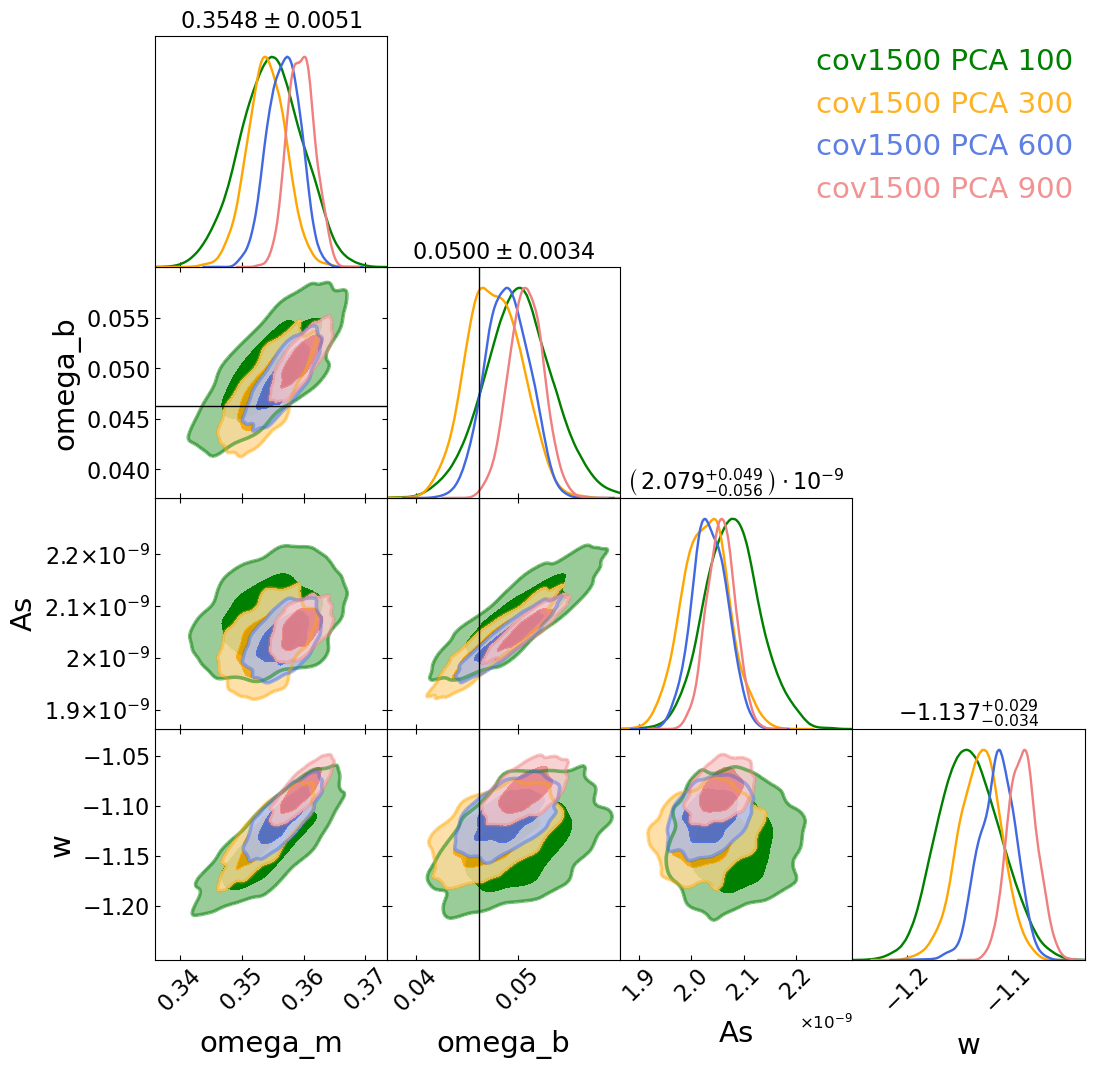

In [284]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])#[[0,2]]
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])


samples_emcee_cov1500_pca100 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_pca100.npy')
samples_emcee_cov1500_pca300 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_pca300.npy')
samples_emcee_cov1500_pca600 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_pca600.npy')
samples_emcee_cov1500_pca900 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_numcov1500_pca900.npy')

samples_getdist_pca100 = MCSamples(samples=samples_emcee_cov1500_pca100,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
samples_getdist_pca300 = MCSamples(samples=samples_emcee_cov1500_pca300,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
samples_getdist_pca600 = MCSamples(samples=samples_emcee_cov1500_pca600,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
samples_getdist_pca900 = MCSamples(samples=samples_emcee_cov1500_pca900,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})


colors = ['lightcoral', 'royalblue', 'orange', 'green']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = colors

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=[samples_getdist_pca100, samples_getdist_pca300, samples_getdist_pca600, samples_getdist_pca900],
    filled=True,
    legend_loc='upper right',
    legend_labels = ['cov1500 PCA 100','cov1500 PCA 300', 'cov1500 PCA 600', 'cov1500 PCA 900' ],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots_4_assignment3/MCMC_corner_task3b_pca_with_numcov1500.jpg',dpi=400, bbox_inches='tight')

<h1 style="color:red"> CHI2 DISTRIBUTION!</h1>
<h1 style="color:red"> COMMENTS!</h1>

### 4. Run task 3 with the noise-free reference model. What difference do you observe in the MCMC chain and the corresponding $\chi^2$ distributions?

#### Noise-Free Reference Model - Analytical Cov Mat

In [285]:
## Function that computes the likelihood
def calc_likelihood_PCA_noisefree(para, cov_inv_pca, N_pca, pca):
    
    params = {'omega_b':reference_params['omega_b'],'w':reference_params['w'], 'omega_m':reference_params['omega_m'], 'As':reference_params['As']}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    pred_vector = cp_nn_model.predictions_np(params)[0]
    pred_vector_transformed = pca.transform([pred_vector*maximum+minimum])[0]
    
    reference_model_noisefree_transformed = pca.transform([reference_model])[0]
       
    # print(pred_vector.shape,reference_model.shape,cov_inv_pca.shape)
    
    delta = pred_vector_transformed - reference_model_noisefree_transformed
    
    
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv_pca,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior

In [286]:
models = np.load('data_4_assignment2/models.npy')
mean = np.mean(models,axis=0) # for numerical stability you should subtract the mean of each element


for N_pca in [100,300,600,900]:#tqdm(np.arange(1,900)):
    
    pca = PCA(n_components=N_pca,svd_solver='full')
    models_pca = pca.fit(models-mean) # Perform the PCA fitting. Now you can use pca for the transformation
    
    # Rotating the covariance matrix
    rotation_matrix = pca.components_.T
    cov_pca = rotation_matrix.T @ cov @ rotation_matrix 
    
    inv_cov_pca = inv(cov_pca) # select the first N_pca elements

    
    sampler_pca_noisefree = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_PCA_noisefree, args=[inv_cov_pca, N_pca, pca])
    sampler_pca_noisefree.run_mcmc(p0, total_steps, progress=True)
    
    samples_emcee_pca_noisefree = sampler_pca_noisefree.get_chain(discard=burning_steps,flat=True)
    np.save('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca'+str(N_pca), samples_emcee_pca_noisefree)
    log_prob_samples_pca_noisefree = sampler_pca_noisefree.get_log_prob(discard=burning_steps, flat=True)
    np.save('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca'+str(N_pca), log_prob_samples_pca_noisefree)
    

100%|██████████| 1000/1000 [01:18<00:00, 12.82it/s]


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


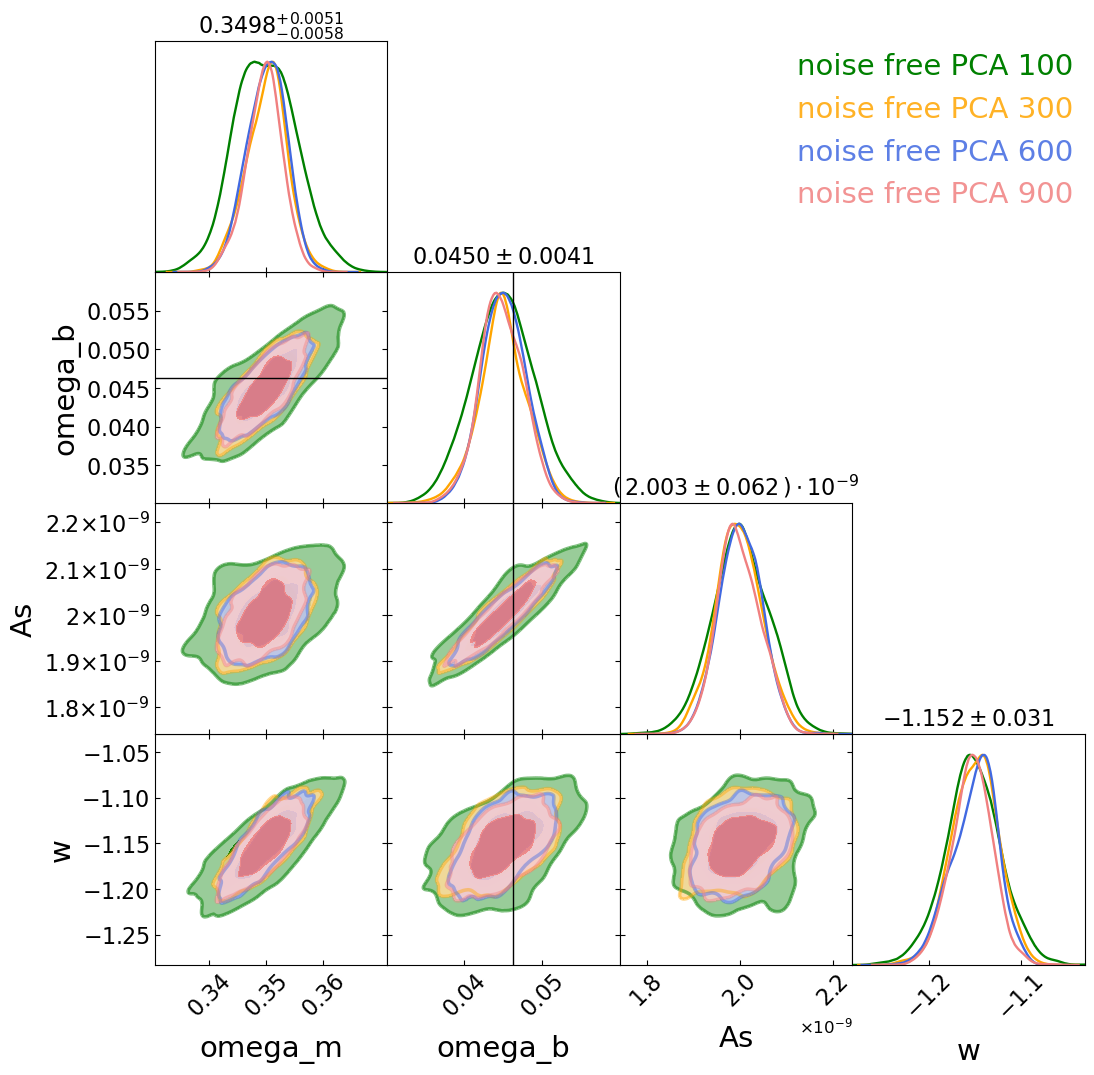

In [290]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])#[[0,2]]
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])


samples_emcee_noisefree_pca100 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca100.npy')
samples_emcee_noisefree_pca300 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca300.npy')
samples_emcee_noisefree_pca600 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca600.npy')
samples_emcee_noisefree_pca900 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca900.npy')

samples_getdist_noisefree_pca100 = MCSamples(samples=samples_emcee_noisefree_pca100,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
samples_getdist_noisefree_pca300 = MCSamples(samples=samples_emcee_noisefree_pca300,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
samples_getdist_noisefree_pca600 = MCSamples(samples=samples_emcee_noisefree_pca600,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
samples_getdist_noisefree_pca900 = MCSamples(samples=samples_emcee_noisefree_pca900,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})


colors = ['lightcoral', 'royalblue', 'orange', 'green']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = colors

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=[samples_getdist_noisefree_pca100, samples_getdist_noisefree_pca300, samples_getdist_noisefree_pca600, samples_getdist_noisefree_pca900],
    filled=True,
    legend_loc='upper right',
    legend_labels = ['noise free PCA 100','noise free PCA 300', 'noise free PCA 600', 'noise free PCA 900' ],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots_4_assignment3/MCMC_corner_task4_pca_with_noisefree.jpg',dpi=400, bbox_inches='tight')

#### Noise-Free Reference Model - Numerical 1.5k Cov Mat 

In [292]:
models = np.load('data_4_assignment2/models.npy')
mean = np.mean(models,axis=0) # for numerical stability you should subtract the mean of each element


for N_pca in [100,300,600,900]:#tqdm(np.arange(1,900)):
    
    pca = PCA(n_components=N_pca,svd_solver='full')
    models_pca = pca.fit(models-mean) # Perform the PCA fitting. Now you can use pca for the transformation
    
    # Rotating the covariance matrix
    rotation_matrix = pca.components_.T
    cov_pca = rotation_matrix.T @ cov_num_1500 @ rotation_matrix 
    
    inv_cov_pca = inv(cov_pca) # select the first N_pca elements

    
    sampler_pca_noisefree_numcov1500 = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_PCA_noisefree, args=[inv_cov_pca, N_pca, pca])
    sampler_pca_noisefree_numcov1500.run_mcmc(p0, total_steps, progress=True)
    
    samples_emcee_pca_noisefree_numcov1500 = sampler_pca_noisefree_numcov1500.get_chain(discard=burning_steps,flat=True)
    np.save('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca'+str(N_pca)+'_numcov1500', samples_emcee_pca_noisefree_numcov1500)
    log_prob_samples_pca_noisefree_numcov1500 = sampler_pca_noisefree_numcov1500.get_log_prob(discard=burning_steps, flat=True)
    np.save('data_4_assignment3/outputs_MCMC/logp_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca'+str(N_pca)+'_numcov1500', log_prob_samples_pca_noisefree_numcov1500)
    

100%|██████████| 1000/1000 [01:15<00:00, 13.18it/s]


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


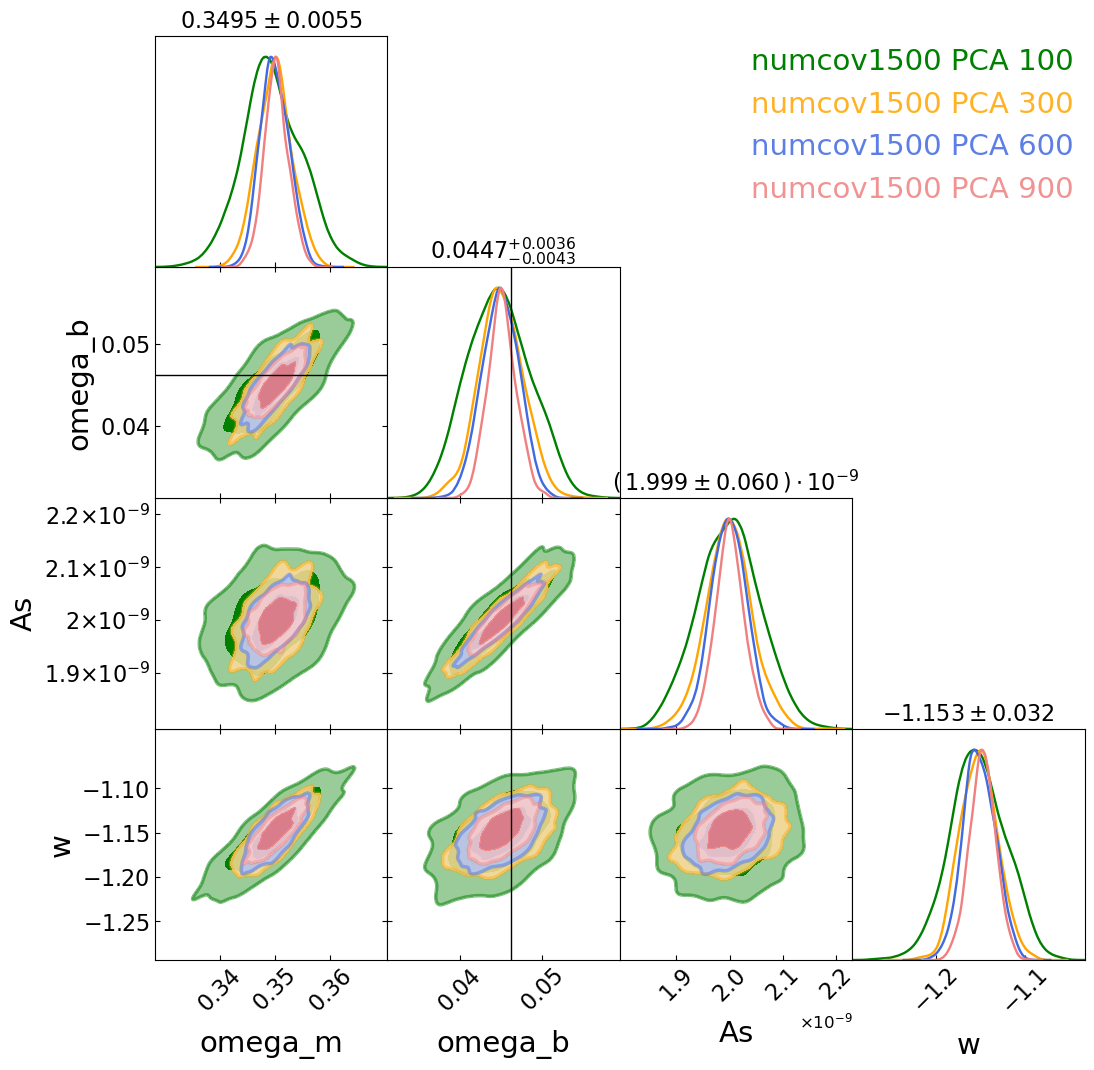

In [293]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])#[[0,2]]
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])


samples_emcee_cov1500_pca100 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca100_numcov1500.npy')
samples_emcee_cov1500_pca300 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca300_numcov1500.npy')
samples_emcee_cov1500_pca600 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca600_numcov1500.npy')
samples_emcee_cov1500_pca900 = np.load('data_4_assignment3/outputs_MCMC/MCMC_s'+str(total_steps)+'_burn'+str(burning_steps)+'_walk'+str(nwalkers)+'_emcee_noisefree_pca900_numcov1500.npy')

samples_getdist_pca100 = MCSamples(samples=samples_emcee_cov1500_pca100,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
samples_getdist_pca300 = MCSamples(samples=samples_emcee_cov1500_pca300,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
samples_getdist_pca600 = MCSamples(samples=samples_emcee_cov1500_pca600,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})
samples_getdist_pca900 = MCSamples(samples=samples_emcee_cov1500_pca900,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})


colors = ['lightcoral', 'royalblue', 'orange', 'green']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = colors

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=[samples_getdist_pca100, samples_getdist_pca300, samples_getdist_pca600, samples_getdist_pca900],
    filled=True,
    legend_loc='upper right',
    legend_labels = ['numcov1500 PCA 100','numcov1500 PCA 300', 'numcov1500 PCA 600', 'numcov1500 PCA 900' ],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots_4_assignment3/MCMC_corner_task4_pca_with_noisefree_numcov1500.jpg',dpi=400, bbox_inches='tight')

#### 4.a Plot and compare the marginalised constraints on $\Omega_\mathrm{m}$ and $A_s$, as a function of the number of PCA elements. What do you observe?


#### 4.b To check if your answer in 4.a is robust, run multiple MCMC chains with the 1.5 covariance matrix and a fixed number of PCA elements. How big are the variations on the marginalised errors on $\Omega_\mathrm{m}$ and $A_s$? Is your answer in 4.a reliable? What can you improve to make 4.a reliable?

### 5. Bonus: Use an MCMC sampler not described in the attached notebook. Compare its performance (speed, accuracy) to the samplers we provided.
###